In [7]:
# DataFrames
import numpy as np
import pandas as pd
import polars as pl
from IPython.display import display, HTML

# Graphing utilities
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import graphs

# Data cleaning & Database
from openpyxl import load_workbook
import process as proc
import db_connect
connection = db_connect.start_conn()

# Encoding
# from dirty_cat import SuperVectorizer # https://stephenleo.github.io/data-science-blog/data-science-blog/ml/feature_engineering.html#dirty-cat
from category_encoders import TargetEncoder

# PCA Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

# Auto-reload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# test = load_workbook('data\economic\interest_rate\FRBNY-SCE-Data.xlsx', read_only=True)
# print(test.sheetnames)
sheets = ['Disclaimer', 'License', 'Notes', 'Inflation expectations', 'Inflation expectations Demo', 'Inflation uncertainty', 'Inflation uncertainty Demo', 
 'Home price expectations', 'Home price expectations Demo', 'Home price uncertainty', 'Home price uncertainty Demo', 'Commodity expectations', 
 'Earnings growth', 'Earnings growth Demo', 'Earnings uncertainty', 'Earnings uncertainty Demo', 'Job separation expectation', 'Job separation expectation Demo', 
 'Job finding expectations', 'Job finding expectations Demo', 'Moving expectations', 'Moving expectations Demo', 
 'Unemployment Expectations', 'Unemployment Expectations Demo', 'HH Income Change', 'HH Income Change Demo', 'HH Spending Change', 'HH Spending Change Demo', 
 'Taxes Change', 'Taxes Change Demo', 'Credit availability', 'Household financial situation', 'Delinquency expectations', 'Delinquency expectations Demo', 
 'Interest rate expectations', 'Interest rate expectations Demo', 'Stock Prices', 'Stock Prices Demo', 'Government debt', 'Government debt Demo', 
 'Inflation expectations distr', 'Prob of Infl Outcome', 'Prob of Infl Outcome Demo', 'Five-year ahead Infl Exp', 'Five-year ahead Infl Exp Demo']

test = pl.read_excel('data\economic\interest_rate\FRBNY-SCE-Data.xlsx', sheet_name='Inflation Expectations')
test



<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
C:\Users\yangt\AppData\Local\Temp\ipykernel_29048\2632706508.py:12: SyntaxWarning: invalid escape sequence '\e'
  test = pl.read_excel('data\economic\interest_rate\FRBNY-SCE-Data.xlsx', sheet_name='Inflation Expectations')
C:\Users\yangt\AppData\Local\Temp\ipykernel_29048\2632706508.py:12: SyntaxWarning: invalid escape sequence '\e'
  test = pl.read_excel('data\economic\interest_rate\FRBNY-SCE-Data.xlsx', sheet_name='Inflation Expectations')


ValueError: no matching sheet found when `sheet_name` is 'Inflation Expectations'

# General Data Exploration & Visualization

## Sale Counts

### Load in Data

In [9]:
# Getting Data
query_annualSales_byBoro = """
SELECT EXTRACT(YEAR FROM "SALE DATE") as year, 
       "BOROUGH",
       COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(YEAR FROM "SALE DATE"), "BOROUGH"
ORDER BY year, "BOROUGH"
"""
annual_byBoro = pl.read_database(query = query_annualSales_byBoro, connection = connection)

annual_byBoro_roc1 = annual_byBoro.sort(["BOROUGH", "year"]).with_columns(
    (pl.col("count").pct_change().over("BOROUGH")*100).alias("roc")
)
annual_sales=annual_byBoro.group_by("year").agg(pl.col("count").sum().alias("count")).sort("year")
annual_sales_roc1=annual_sales.sort("year").with_columns(
    (pl.col("count").pct_change()*100).alias("roc")
)

annual_byBoro_pd = annual_byBoro.to_pandas()
annual_byBoro_roc1_pd = annual_byBoro_roc1.to_pandas()
annual_sales_pd = annual_sales.to_pandas()
annual_sales_roc1_pd = annual_sales_roc1.to_pandas()

borough_names = {
    1: "Manhattan", 
    2: "Bronx", 
    3: "Brooklyn", 
    4: "Queens", 
    5: "Staten Island"
}

annual_byBoro_pd['borough_name'] = annual_byBoro_pd['BOROUGH'].map(borough_names)
annual_byBoro_roc1_pd['borough_name'] = annual_byBoro_roc1_pd['BOROUGH'].map(borough_names)

In [10]:
query_monthlySales_byBoro = """
SELECT EXTRACT(MONTH FROM "SALE DATE") as month,
    "BOROUGH",
    COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(MONTH FROM "SALE DATE"), "BOROUGH"
ORDER BY month, "BOROUGH"
"""

monthly_byBoro = pl.read_database(query = query_monthlySales_byBoro, connection = connection)

monthly_byBoro_roc1 = monthly_byBoro.sort("month").with_columns(
    (pl.col("count").pct_change().over("BOROUGH")*100).alias("roc")
).to_pandas()
monthly_sales=monthly_byBoro.group_by("month").agg(pl.col("count").sum().alias("count")).sort("month")
monthly_sales_roc1=monthly_sales.sort("month").with_columns(
    (pl.col("count").pct_change()*100).alias("roc")
).to_pandas()

monthly_byBoro = monthly_byBoro.to_pandas()
monthly_sales = monthly_sales.to_pandas()

monthly_byBoro['borough_name'] = monthly_byBoro['BOROUGH'].map(borough_names)
monthly_byBoro_roc1['borough_name'] = monthly_byBoro_roc1['BOROUGH'].map(borough_names)

In [11]:
query_annualSales_neighborhoods = """
SELECT EXTRACT(YEAR FROM "SALE DATE")::INTEGER as year,
    "NEIGHBORHOOD", 
    "BOROUGH",
    COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(YEAR FROM "SALE DATE"), "NEIGHBORHOOD", "BOROUGH"
ORDER BY year
"""

nborhood_annual_byBoro = pl.read_database(query = query_annualSales_neighborhoods, connection = connection)

nborhood_annual_byBoro_roc1 = nborhood_annual_byBoro.sort('year').with_columns(
    (pl.col('count').pct_change().over("NEIGHBORHOOD")*100).alias("roc")
).to_pandas()

nborhood_annual_byBoro = nborhood_annual_byBoro.to_pandas()

### Graphs

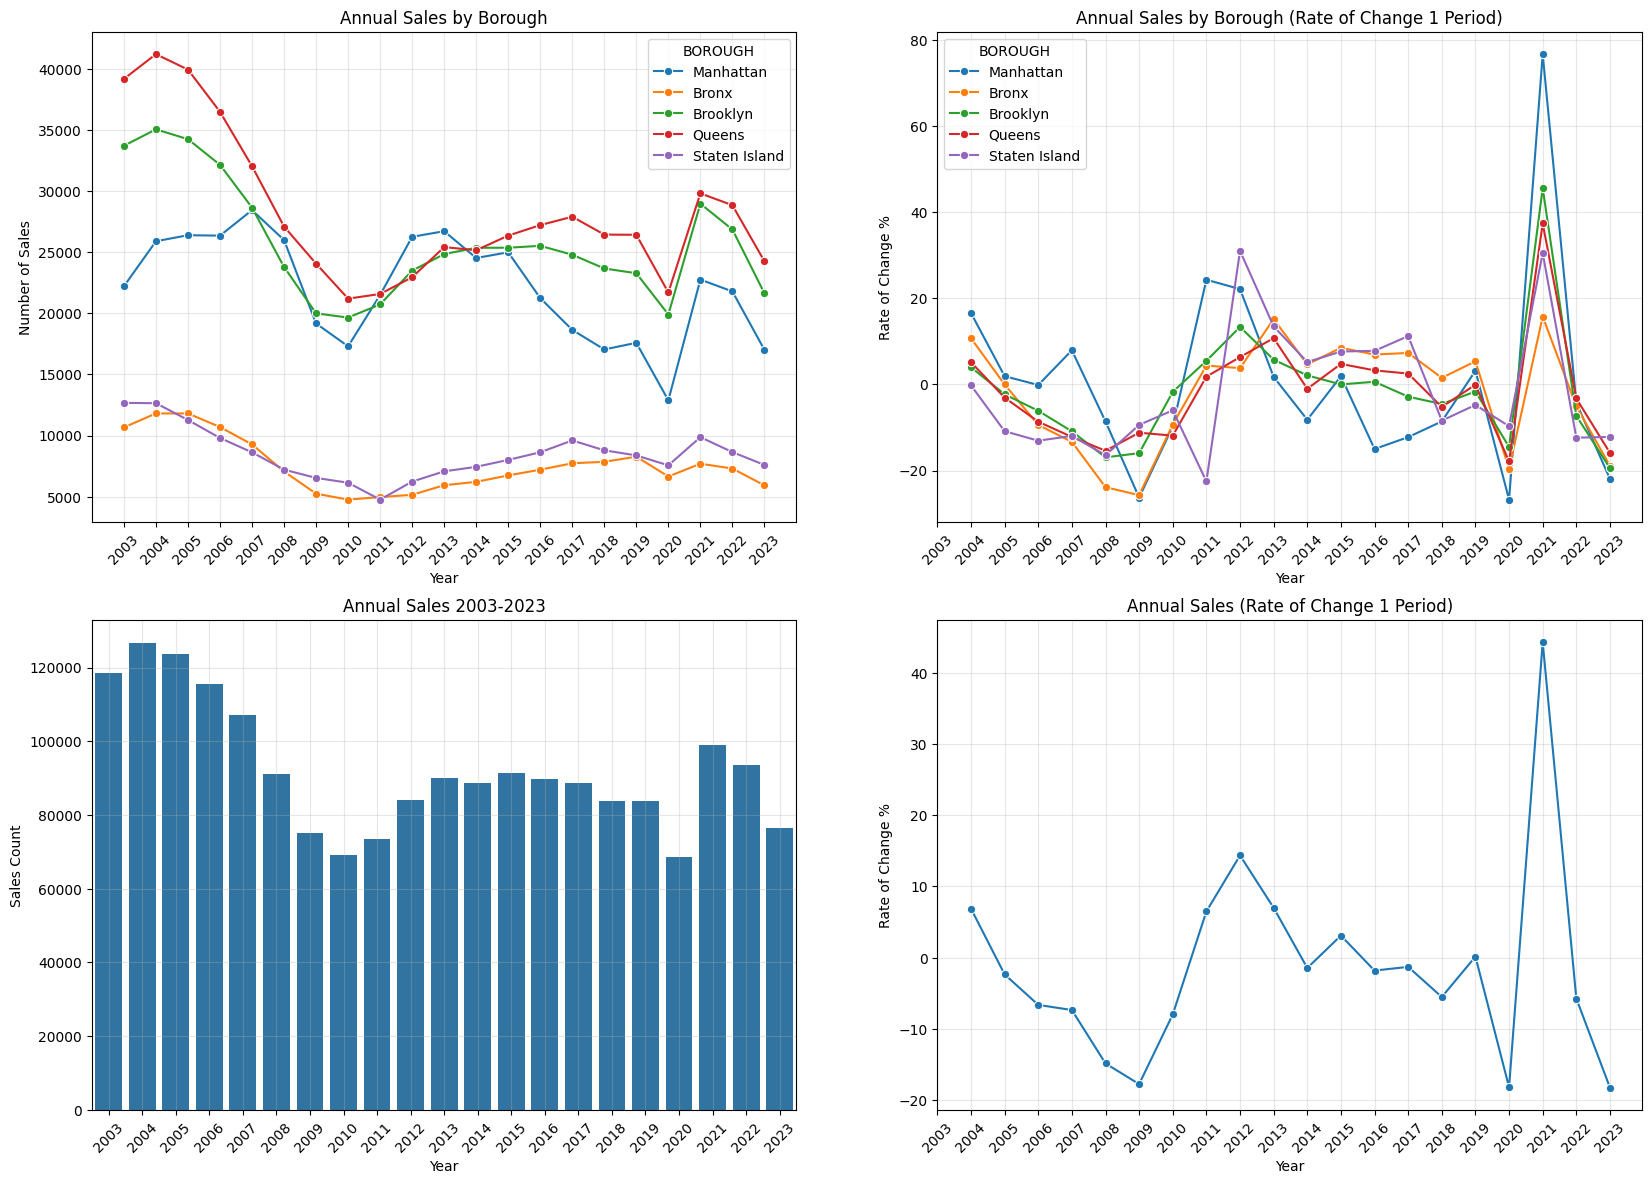

In [ ]:
fig, axs = plt.subplots(2,2)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_byBoro_pd,
    x='year',
    y='count',
    marker='o',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    title='Annual Sales by Borough',
    xticks=sorted(annual_byBoro_pd['year'].unique()),
    xlabel='Year',
    xrot=45,
    ylabel='Number of Sales',
    leg_on=True,
    leg_pos='upper right',
    leg_outer=False,
    leg_labels=annual_byBoro_pd['borough_name'].unique(),
    ax = axs[0,0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_byBoro_roc1_pd,
    x='year',
    y='roc',
    marker='o',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    title='Annual Sales by Borough (Rate of Change 1 Period)',
    xticks=sorted(annual_byBoro_pd['year'].unique()),
    xlabel='Year',
    xrot=45,
    ylabel='Rate of Change %',
    leg_on=True,
    leg_pos='upper left',
    leg_outer=False,
    leg_labels=annual_byBoro_pd['borough_name'].unique(),
    ax = axs[0,1]
)

graphs.MatPlot.makePlot(
    chart='bar',
    data=annual_sales_pd,
    x='year',
    y='count',
    title='Annual Sales 2003-2023',
    xticks=[str(year) for year in annual_sales['year']],
    xlabel='Year',
    xrot=45,
    ylabel='Sales Count',
    leg_on=False,
    ax=axs[1,0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=annual_sales_roc1_pd,
    x='year',
    y='roc',
    marker='o',
    title='Annual Sales (Rate of Change 1 Period)',
    xticks=annual_sales_roc1_pd['year'],
    xlabel='Year',
    xrot=45,
    ylabel='Rate of Change %',
    leg_on=False,
    ax=axs[1,1]
)

# axs[1,0].annotate(
#     f'{annual_sales_pd["count"].min()}', 
#     (annual_sales_pd["count"].idxmin(), annual_sales_pd["count"].min())
# )

fig.set_figheight(14)
fig.set_figwidth(20)

In [ ]:
html = """
<div style="display: flex; gap: 25px">
    <div>{df1}</div>
    <div>{df2}</div>
    <div>{df3}</div>
    <div>{df4}</div>
</div>
""".format(
    df1=annual_byBoro_pd.nlargest(10,'count').to_html(), 
    df2=annual_byBoro_roc1_pd.nlargest(10,'roc').to_html(),
    df3=annual_sales_pd.nlargest(10,'count').to_html(),
    df4=annual_sales_roc1_pd.nlargest(10,'roc').to_html()
    )

display(HTML(html))

,year,BOROUGH,count,borough_name
8,2004,4,41199,Queens
13,2005,4,39937,Queens
3,2003,4,39177,Queens
18,2006,4,36482,Queens
7,2004,3,35048,Brooklyn
12,2005,3,34243,Brooklyn
2,2003,3,33706,Brooklyn
17,2006,3,32146,Brooklyn
23,2007,4,32032,Queens
93,2021,4,29812,Queens


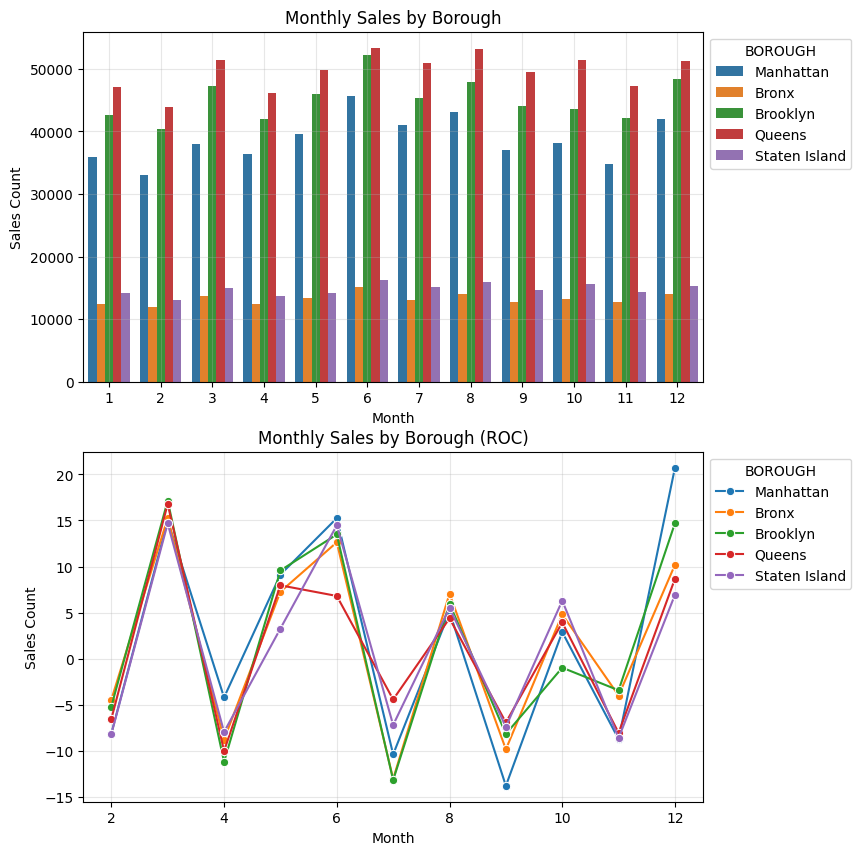

In [ ]:
fig, axs = plt.subplots(2,1)

graphs.MatPlot.makePlot(
    chart='bar',
    data=monthly_byBoro,
    x='month',
    y='count',
    title='Monthly Sales by Borough',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    # xticks=range(1,13),
    xlabel='Month',
    ylabel='Sales Count',
    leg_on=True,
    leg_pos='upper left',
    leg_outer=True,
    leg_bbox=(1,1),
    leg_labels=monthly_byBoro['borough_name'].unique(),
    ax = axs[0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=monthly_byBoro_roc1,
    x='month',
    y='roc',
    marker='o',
    title='Monthly Sales by Borough (ROC)',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    xlabel='Month',
    ylabel='Sales Count',
    leg_on=True,
    leg_pos='upper left',
    leg_outer=True,
    leg_bbox=(1,1),
    leg_labels=monthly_byBoro_roc1['borough_name'].unique(),
    ax = axs[1]
)

# plt.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)

In [ ]:
html = """
<div style="display: flex; gap: 25px">
    <div>{df1}</div>
    <div>{df2}</div>
</div>
""".format(
    df1=monthly_byBoro.nlargest(10, 'count').to_html(), 
    df2=monthly_byBoro_roc1.nlargest(10, 'roc').to_html(),
    )

display(HTML(html))

,month,BOROUGH,count,borough_name
28,6,4,53276,Queens
38,8,4,53135,Queens
27,6,3,52170,Brooklyn
48,10,4,51386,Queens
13,3,4,51360,Queens
58,12,4,51337,Queens
33,7,4,50910,Queens
23,5,4,49883,Queens
43,9,4,49446,Queens
57,12,3,48311,Brooklyn


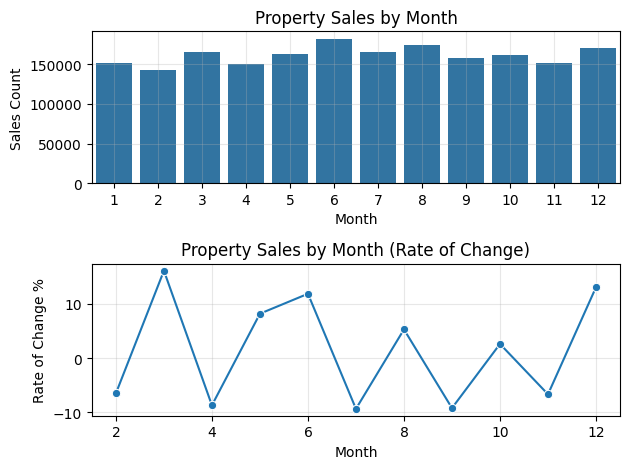

In [ ]:
fig, axs = plt.subplots(2,1)

graphs.MatPlot.makePlot(
    chart='bar',
    data=monthly_sales,
    x='month',
    y='count',
    title='Property Sales by Month',
    xlabel='Month',
    ylabel='Sales Count',
    leg_on=False,
    ax = axs[0]
)

graphs.MatPlot.makePlot(
    chart='line',
    data=monthly_sales_roc1,
    x='month',
    y='roc',
    marker='o',
    title='Property Sales by Month (Rate of Change 1 Period)',
    xlabel='Month',
    ylabel='Rate of Change %',
    leg_on=False,
    ax = axs[1]
)

plt.tight_layout()

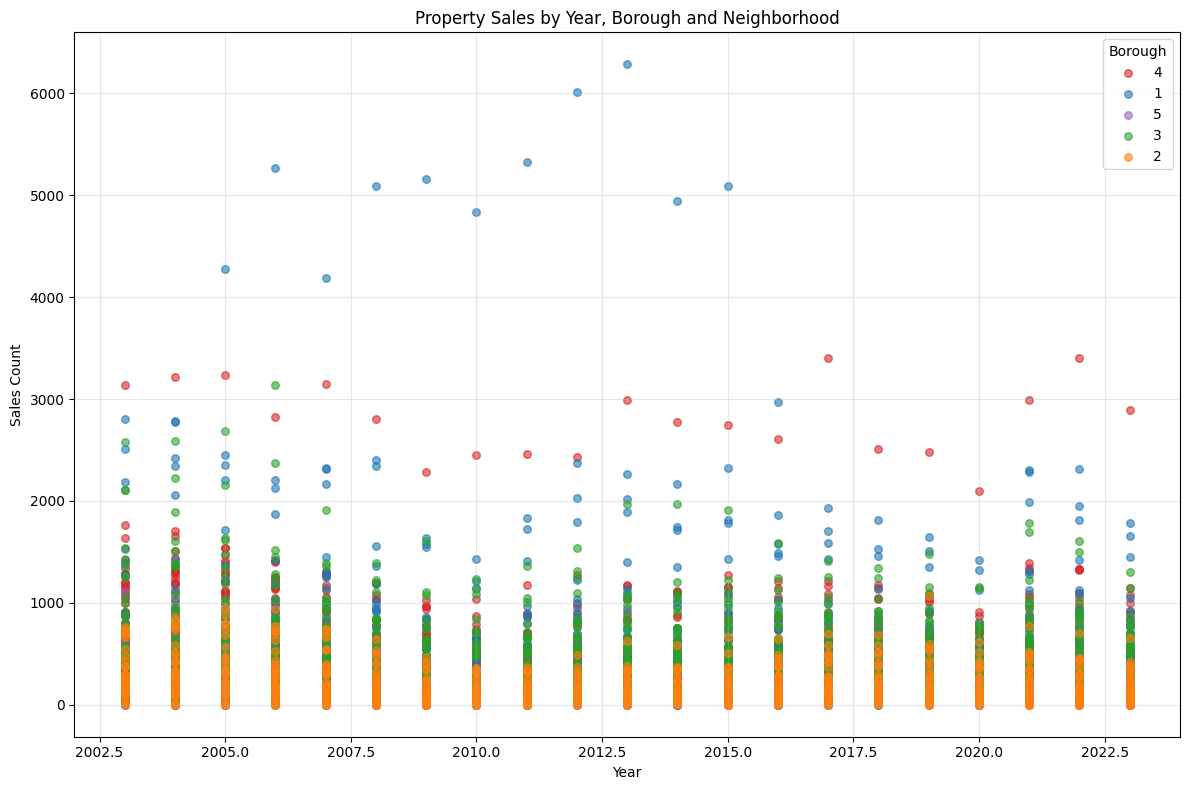

In [172]:
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each borough
borough_colors = {
    1: '#1f77b4',  # Manhattan
    2: '#ff7f0e',  # Bronx
    3: '#2ca02c',  # Brooklyn
    4: '#d62728',  # Queens
    5: '#9467bd'   # Staten Island
}

# Plot each borough with different colors
for borough in nborhood_annual_byBoro['BOROUGH'].unique():
    borough_data = nborhood_annual_byBoro[nborhood_annual_byBoro['BOROUGH'] == borough]
    ax.scatter(
        borough_data['year'], 
        borough_data['count'],
        alpha=0.6,
        s=30,
        c=borough_colors[borough],
        label=borough
    )

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Sales Count')
ax.set_title('Property Sales by Year, Borough and Neighborhood')
ax.grid(True, alpha=0.3)

# Add legend for boroughs
ax.legend(title='Borough')

# Optional: Add hover functionality for interactive exploration
# This requires using plt.gcf().canvas.mpl_connect() or using plotly instead

plt.tight_layout()
plt.show()

In [229]:
html = """
<div style="display: flex; gap: 25px">
    <div>{df1}</div>
    <div>{df2}</div>
    <div>{df3}</div>
</div>
""".format(
    df1=nborhood_annual_byBoro.nlargest(10, 'count').to_html(), 
    df2=nborhood_annual_byBoro_roc1.nlargest(10, 'roc').to_html(),
    df3=(nborhood_annual_byBoro
         .sort_values(['year', 'count'], ascending=[True, False])
         .groupby('year')
         .first()
         .reset_index()
         ).to_html(),
         )

display(HTML(html))

,year,NEIGHBORHOOD,BOROUGH,count
2724,2013,MIDTOWN WEST,1,6284
2467,2012,MIDTOWN WEST,1,6012
2209,2011,MIDTOWN WEST,1,5324
926,2006,MIDTOWN WEST,1,5269
1694,2009,MIDTOWN WEST,1,5158
3237,2015,MIDTOWN WEST,1,5093
1440,2008,MIDTOWN WEST,1,5091
2981,2014,MIDTOWN WEST,1,4946
1951,2010,MIDTOWN WEST,1,4838
667,2005,MIDTOWN WEST,1,4273


## Economic Data

In [ ]:
query_overnight = "SELECT * FROM overnight_rates;"

overnight_rates = pl.read_database(query=query_overnight, connection=connection, infer_schema_length=None).to_pandas()

overnight_monthly = overnight_rates.groupby([overnight_rates['Effective Date'].dt.to_period('M'), 'Rate Type']).agg({'Rate (%)': 'mean', 'Volume ($Billions)': 'mean'})

In [38]:
overnight_monthly = overnight_rates.groupby([overnight_rates['Effective Date'].dt.to_period('M'), 'Rate Type']).agg({'Rate (%)': 'mean', 'Volume ($Billions)': 'mean'})
overnight_monthly

Rate (%)  Volume ($Billions)
Effective Date Rate Type                              
2002-01        EFFR       1.750952                 NaN
2002-02        EFFR       1.746316                 NaN
2002-03        EFFR       1.726190                 NaN
2002-04        EFFR       1.758636                 NaN
2002-05        EFFR       1.759091                 NaN
...                            ...                 ...
2023-12        BGCR       5.308000              623.00
               EFFR       5.330000               97.25
               OBFR       5.320000              242.30
               SOFR       5.335500             1693.75
               TGCR       5.308000              609.55

[565 rows x 2 columns]

In [47]:
overnight_monthly.index.get_level_values(0)

PeriodIndex(['2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06',
             '2002-07', '2002-08', '2002-09', '2002-10',
             ...
             '2023-11', '2023-11', '2023-11', '2023-11', '2023-11', '2023-12',
             '2023-12', '2023-12', '2023-12', '2023-12'],
            dtype='period[M]', name='Effective Date', length=565)

TypeError: Invalid object type at position 0

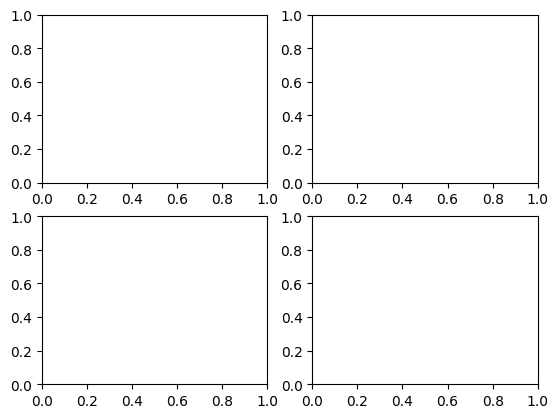

: 

In [ ]:
fig, axs = plt.subplots(2,2)

graphs.MatPlot.makePlot(
    chart='line',
    data=overnight_monthly,
    x=overnight_monthly.index.get_level_values(0),
    y='Rate (%)',
    hue='Rate Type',
    palette=["C0", "C1", "C2", "C3", "C4"],
    title='Overnight Rates 2002-2023',
    # xticks=sorted(annual_byBoro_pd['year'].unique()),
    xlabel='Date',
    xrot=45,
    ylabel='Rate (%)',
    leg_on=True,
    leg_pos='upper right',
    leg_outer=False,
    leg_labels=overnight_rates['Rate Type'].unique(),
    ax = axs[0,0]
)

# plt.tight_layout()
fig.set_figheight(14)
fig.set_figwidth(16)

# Clustering

## PCA-Dimensionality Reduction

In [ ]:
query_rolling_sales = "SELECT * FROM rolling_sales;"
query_overnight = "SELECT * FROM overnight_rates;"
query_treasuries = "SELECT * FROM treasuries;"

rolling_sales = pl.read_database(query=query_rolling_sales, connection=connection, infer_schema_length=None)
overnight = pl.read_database(query=query_overnight, connection=connection, infer_schema_length=None)
treasuries = pl.read_database(query=query_treasuries, connection=connection, infer_schema_length=None)

overnight_rolling = overnight.sort('Effective Date').select([
    'Effective Date', 'Rate Type', 'Rate (%)', 'Volume ($Billions)'
]).with_columns([
    pl.col('Rate (%)').rolling_mean(window_size=30).alias("30d_avg_rate"),
    pl.col('Rate (%)').rolling_mean(window_size=60).alias("60d_avg_rate"),
    pl.col('Rate (%)').rolling_mean(window_size=90).alias("90d_avg_rate")
])

treasuries_rolling = treasuries.sort('Time Period').with_columns((
    [pl.col(col).rolling_mean(window_size=30, min_samples=1).alias(f"{col}_30d_avg") for col in treasuries.columns if col != 'Time Period'] +
    [pl.col(col).rolling_mean(window_size=60, min_samples=1).alias(f"{col}_60d_avg") for col in treasuries.columns if col != 'Time Period'] + 
    [pl.col(col).rolling_mean(window_size=90, min_samples=1).alias(f"{col}_90d_avg") for col in treasuries.columns if col != 'Time Period'] +
    [pl.col(col).shift(45).alias(f"{col}_45d_lag") for col in treasuries.columns if col != 'Time Period']
))

In [93]:
test = pl.read_excel('data/economic/interest_rate/freddiemac_mortgages.xlsx', read_options={"header_row": 6})
cols = ['Week', '30yr_FRM', '30yr_f&p', '15yr_FRM', '15yr_f&p', '5/1_ARM', '5/1_ARM_f&p', '5/1_ARM_margin', '30yrFRM_5/1ARM_spread']
test.columns = cols
test[1650:1660]

Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 4, falling back to string
Could not determine dtype for column 5, falling back to string
Could not determine dtype for column 6, falling back to string
Could not determine dtype for column 7, falling back to string
Could not determine dtype for column 8, falling back to string


Week,30yr_FRM,30yr_f&p,15yr_FRM,15yr_f&p,5/1_ARM,5/1_ARM_f&p,5/1_ARM_margin,30yrFRM_5/1ARM_spread
date,f64,str,str,str,str,str,str,str
2002-11-15,5.94,"""0.6""","""5.32""","""0.6""",null,null,null,null
2002-11-22,6.03,"""0.6""","""5.44""","""0.6""",null,null,null,null
2002-11-29,6.13,"""0.6""","""5.57""","""0.5""",null,null,null,null
2002-12-06,6.19,"""0.5""","""5.6""","""0.6""",null,null,null,null
2002-12-13,6.04,"""0.5""","""5.46""","""0.5""",null,null,null,null
2002-12-20,6.03,"""0.6""","""5.42""","""0.6""",null,null,null,null
2002-12-27,5.93,"""0.6""","""5.32""","""0.6""",null,null,null,null
2003-01-03,5.85,"""0.6""","""5.24""","""0.6""",null,null,null,null
2003-01-10,5.95,"""0.5""","""5.33""","""0.6""",null,null,null,null


In [ ]:
overnight_rolling = overnight.sort('Effective Date').select([
    'Effective Date', 'Rate Type', 'Rate (%)', 'Volume ($Billions)'
]).with_columns([
    pl.col('Rate (%)').rolling_mean(window_size=30).alias("30d_avg_rate"),
    pl.col('Rate (%)').rolling_mean(window_size=60).alias("60d_avg_rate"),
    pl.col('Rate (%)').rolling_mean(window_size=90).alias("90d_avg_rate")
])


Effective Date,Rate Type,Rate (%),Volume ($Billions),30d_avg_rate,60d_avg_rate,90d_avg_rate
date,str,f64,i64,f64,f64,f64
2002-01-02,"""EFFR""",1.92,null,null,null,null
2002-01-03,"""EFFR""",1.72,null,null,null,null
2002-01-04,"""EFFR""",1.61,null,null,null,null
2002-01-07,"""EFFR""",1.61,null,null,null,null
2002-01-08,"""EFFR""",1.61,null,null,null,null
…,…,…,…,…,…,…
2023-12-29,"""EFFR""",5.33,59,5.325333,5.319,5.318667
2023-12-29,"""OBFR""",5.32,110,5.325333,5.319,5.318667
2023-12-29,"""TGCR""",5.33,594,5.326333,5.3195,5.318889


In [54]:
FRB_H15 = proc.interestRate.HR15_pl('data/fed_data/interest_rate/FRB_H15.csv')
db_connect.write_db(FRB_H15, 'treasuries')

In [50]:
import polars.selectors as cs

In [32]:
test.filter(pl.col('1M') == 'ND')


Time Period,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
date,str,str,str,str,str,str,str,str,str,str,str
2001-09-03,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2001-09-11,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2001-09-12,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2001-10-08,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2001-11-12,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
…,…,…,…,…,…,…,…,…,…,…,…
2024-11-28,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2024-12-25,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""
2025-01-01,"""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND""","""ND"""


In [ ]:
rolling_sales_Y = rolling_sales[]

ValueError: could not convert string to float: 'BATHGATE'

## K-means

In [ ]:
all_data.head()
features = all_data[[]]

BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,date
2,"""BATHGATE""","""01 ONE FAMILY HOMES""","""1""",3035,5,"""""","""A9""","""451 EAST 178 STREET""","""""",10457,1,0,1,1287,1992,1899,1,"""A9""",0,2009-12-07
2,"""BATHGATE""","""01 ONE FAMILY HOMES""","""1""",3046,42,"""""","""A1""","""2069 BATHGATE AVENUE""","""""",10457,1,0,1,1964,1424,1899,1,"""A1""",100,2009-04-28
2,"""BATHGATE""","""01 ONE FAMILY HOMES""","""1""",3046,42,"""""","""A1""","""2069 BATHGATE AVE""","""""",10457,1,0,1,1964,1424,1899,1,"""A1""",100,2009-04-13
2,"""BATHGATE""","""01 ONE FAMILY HOMES""","""1""",3048,19,"""""","""A5""","""2186 BATHGATE AVENUE""","""""",10457,1,0,1,1768,1188,1901,1,"""A5""",345752,2009-03-16
2,"""BATHGATE""","""01 ONE FAMILY HOMES""","""1""",3048,28,"""""","""A1""","""540 EAST 182ND STREET""","""""",10457,1,0,1,1209,1048,1901,1,"""A1""",0,2009-05-14


# Regression Analysis

In [ ]:
query_all = """
SELECT * FROM rolling_sales;
"""

all_data = pl.read_database(query=query_reg, connection=connection)

In [42]:
all_data.filter(pl.col('EASE-MENT') != "")

BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,date
4,"""LONG ISLAND CITY""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",18,5,"""E""","""U7""","""5 STREET""","""""",11101,0,0,0,0,0,0,3,"""U7""",0,2009-05-15
2,"""HUNTS POINT""","""41 TAX CLASS 4 - OTHER""","""4""",2604,252,"""E""","""Z7""","""977 EAST 149TH STREET""","""""",10455,0,0,0,93999,0,0,4,"""Z7""",18079380,2010-10-02
5,"""ROSEBANK""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",2983,57,"""E""","""U9""","""ST JOHNS AVENUE""","""""",10305,0,0,0,0,0,0,3,"""U9""",0,2011-12-21
5,"""ROSEBANK""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",2983,60,"""E""","""U2""","""245 ST JOHN'S AVENUE""","""""",10305,0,0,0,0,0,0,3,"""U2""",0,2011-05-02
5,"""ROSSVILLE-RICHMOND VALLEY""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",7620,1,"""E""","""U1""","""ARTHUR KILL ROAD""","""""",10307,0,0,0,0,0,0,3,"""U1""",0,2011-12-02
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5,"""HUGUENOT""","""41 TAX CLASS 4 - OTHER""","""4""",6821,61,"""E""","""Z7""","""90 WEST TERRACE""","""""",10312,0,0,0,1000,0,0,4,"""Z7""",5000,2015-08-20
1,"""FINANCIAL""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",58,1,"""E""","""U7""","""1 WORLD TRADE CENTER""","""""",10007,0,0,0,0,0,0,3,"""U7""",0,2008-09-24
1,"""CHELSEA""","""18 TAX CLASS 3 - UTILITY PROP…","""3""",701,30,"""E""","""U6""","""509 WEST 29 STREET""","""""",10001,0,0,0,0,0,0,3,"""U6""",0,2005-11-04
